# Dehazing AutoEncoder

* AutoEncoder is an Unsupervised Neural Network Based Machine Learning algorithm. It is often used to learn efficient codings of unlabeled data and consists of an encoder (transforms the input data) and decoder (recreates the input data from its encoded representation)

* We can use AutoEncoders for convolutional tasks such as Image Noise reduction and in our case Dehazing the input image to a clearer representation of the same. The Dehazing Convolutional AutoEncoder would be triggered if the default KeyPoint RCNN model is unable to detect Keypoints, indicating the presence of Haze

* The reference paper for the Convolutional AutoEncoder is: https://arxiv.org/pdf/2008.10325v1.pdf

## Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, ReLU, MaxPooling2D, UpSampling2D, Conv2DTranspose, Input, Dropout, AveragePooling2D
import keras.utils as image
import pickle

try:
  import patoolib

except:
  !pip install patool
  import patoolib

## Importing Dataset

* We are using the patoolib library to extract our image archive files which contains Ground Truth Images and their corresponding Haze Images. The dataset for training this model is the O-Haze 2018 NITRE Dataset.

* The reference for this dataset is: https://data.vision.ee.ethz.ch/cvl/ntire18/o-haze/

In [ ]:
patoolib.extract_archive("/content/drive/MyDrive/Datasets/HazeTrain.zip")

INFO patool: Extracting /content/drive/MyDrive/Datasets/HazeTrain.zip ...
INFO:patool:Extracting /content/drive/MyDrive/Datasets/HazeTrain.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_8q9kli06 -- /content/drive/MyDrive/Datasets/HazeTrain.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_8q9kli06 -- /content/drive/MyDrive/Datasets/HazeTrain.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/drive/MyDrive/Datasets/HazeTrain.zip extracted to `HazeTrain' (multiple files in root).
INFO:patool:... /content/drive/MyDrive/Datasets/HazeTrain.zip extracted to `HazeTrain' (multiple files in root).


'HazeTrain'

## Preparing the Files

* After Extraction we will take the paths to the clear and hazy image files. Then we have defined two seperate python list in which we first load the respective image, resize is to the target size of `(512, 512, 3)` and then append it as an array. Finally we convert them to a NumPy Array to be used for training the model

In [ ]:
hazy = "/content/HazeTrain/HazeTrain/input/"
clear = "/content/HazeTrain/HazeTrain/output/"

hazy_img = []
for filename in os.listdir(hazy):
    if filename.endswith(".jpg"):
        img = image.load_img(hazy+filename, target_size=(512, 512))
        hazy_img.append(image.img_to_array(img))
hazy_img = np.array(hazy_img)

clear_img = []
for filename in os.listdir(clear):
    if filename.endswith(".jpg"):
        img = image.load_img(clear+filename, target_size=(512, 512))
        clear_img.append(image.img_to_array(img))
clear_img = np.array(clear_img)

## Function for Visualisation

* We will create a function that would display first 10 results of our input image.

In [ ]:
def visualisation(X, n=10, title=""):
    plt.figure(figsize=(15, 5))

    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)


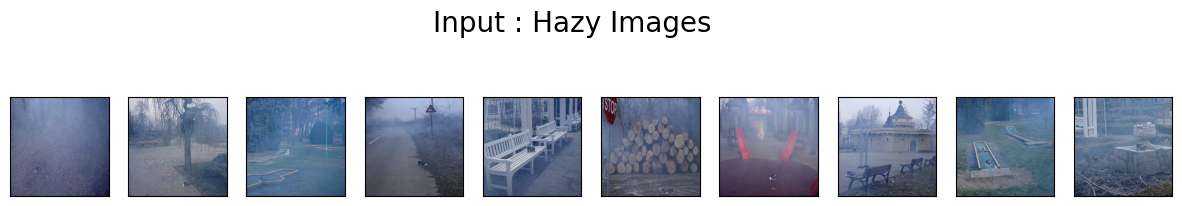

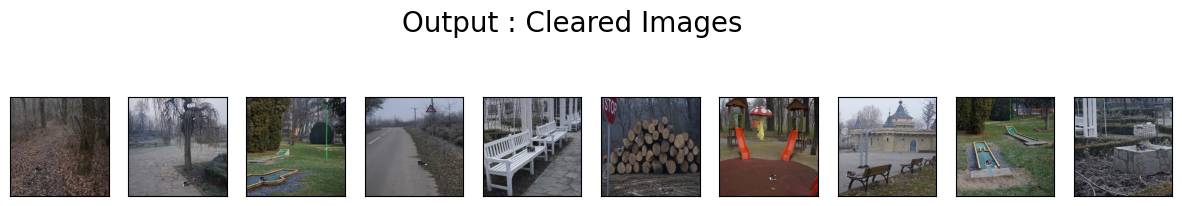

In [ ]:
visualisation(hazy_img, title="Input : Hazy Images")
visualisation(clear_img, title="Output : Cleared Images")

## Making the Model

We would be constructing the Light Convolutional AutoEncoder on the above mentioned reference link with the following Architecture:

* Encoder:
  
  * 2 x Convolutional Layers (ReLU Activated)
  
  * 2 x AveragePooling2D

* Latent Space:

  * 2 x Dense Layers (ReLU Activated)

  * Dense Layers brings **non linearity** in our model and thus they make it easier to model complex mathematical function to extract the essential features with much ease


* Decoder: 2 x Convolutional Layers (ReLU Activated)

  * 2 x Convolutional 2D Transpose Layers (ReLU Activated)
  
  * 2 x UpSampling2D

In [ ]:
input_layer_lca = Input(shape=(512, 512, 3), name="INPUT")
x = Conv2D(50, (3, 3), activation='relu', padding='same')(input_layer_lca)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(50, (3, 3), activation='relu', padding='same')(x)
x = AveragePooling2D((2, 2))(x)

x = Dense(10, activation='relu')(x)
latent_layer = Dense(10, activation='relu', name='latent')(x)

x = Conv2DTranspose(50, (3, 3), activation='relu', padding='same')(latent_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(50, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
output_layer_lca = Conv2DTranspose(3, (3, 3), padding='same', name="OUTPUT")(x)

We are compiling the model with the following parameters:

* Loss: Mean Square Error (MSE)

  Mean Squared Error Loss function helps to variation of extreme values and thus supporting a smooth gradient descent making it an optimal loss function.

* Optimizer: Adaptive Moment (ADAM)

  ADAM Optimizer function employs the ADAM equation and is an ideal optimizer function, thanks to easier implementation and faster convergence than Stochastic Gradient Descent

In [ ]:
lca = Model(input_layer_lca, output_layer_lca)
lca.compile(optimizer=keras.optimizers.Adam(), loss='mse', run_eagerly=True)

We are training our model for 250 iterations or epochs with a batch size of 32. With the help of batch size we can break down our datasets into smaller batches and thus helps to train the model much faster in comparision to keep the batch size equal to the number of records we have

In [ ]:
lca.fit(hazy_img, clear_img, epochs=250, batch_size=32)

Epoch 1/10


We now get the encoded layer by using `get_layer()` function and thus we use to create our encoded lca Model which then takes in our input and produces and output

In [ ]:
get_encoded_lca = Model(inputs=lca.input, outputs=lca.get_layer("latent").output)

In [ ]:
lca_preds = lca.predict(hazy_img)

2/2 [==============================] - 17s 4s/step


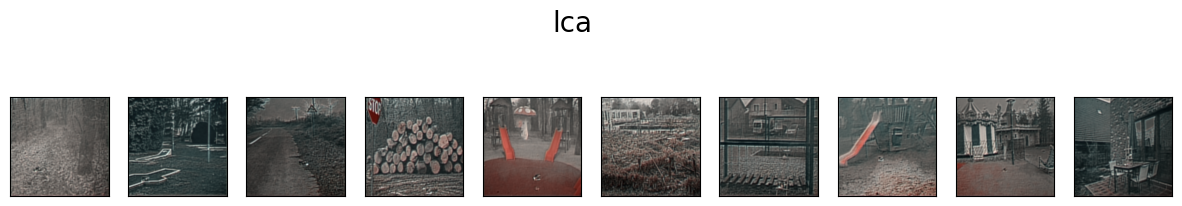

In [ ]:
visualisation(lca_preds, title="lca")

## Saving the Model

We are using Python Pickle to save our model in the binary format. Pickling a model has the advantage of saving a model like a pdf so that you do not need to train the model all over again and just load the model and make the corresponding predictions

In [ ]:
with open('lca_2.pkl', 'wb') as f:
  pickle.dump(lca, f)

## Plotting the Loss Curves

In the below array **y** we have the loss values stored, which we would then feed to **matplotlib** to plot our loss curves with:

* y-axis: Loss Values
* x-axis: Number of Epochs

Loss Curves helps us understand the progress and how the model improves and learn the parameters as the number of iterations increase

In [ ]:
y = np.array([9602.5439, 7809.7280, 5675.0303, 3852.1562, 3382.4854, 2988.0144, 2195.2202, 1838.1949, 1940.7838, 2139.9634, 2214.3755, 2180.1292, 2159.3108, 2069.9204,1892.6265, 1781.4436, 1710.5134, 1670.0831, 1661.9324, 1650.2018,
1652.1974, 1644.6886, 1633.4291, 1603.4177, 1588.1342, 1561.0779, 1535.5859, 1516.7020, 1501.7185, 1485.5728, 1476.9812, 1470.7982, 1462.4894, 1455.8114, 1447.7336, 1441.1083, 1441.5542, 1473.6259, 1560.4672, 1423.1732,
1559.3127, 1480.2659, 1516.9830, 1423.8163, 1509.3314, 1411.9664, 1480.2720, 1413.9692, 1440.6633, 1424.3961, 1401.8708, 1431.4614, 1392.5698, 1422.8469, 1393.6334, 1391.2324,
1394.2677,
1375.0231,
1393.8738,
1368.9519,
1384.3909,
1357.3080,
1372.8826,
1347.7682,
1357.7679,
1336.3187,
1344.6626,
1328.0328,
1326.3253,
1340.5876,
1321.0143,
1306.3409,
1318.3959,
1316.7206,
1295.8640,
1296.4185,
1309.2400,
1300.4860,
1284.4368,
1274.8420,
1275.2346,
1280.8049,
1306.5521,
1372.3828,
1316.1339,
1267.3120,
1311.4764,
1264.3851,
1276.4070,
1267.9904,
1252.6605,
1268.7825,
1250.7206,
1236.0232,
1255.1632,
1277.0017,
1247.9376,
1225.6742,
1245.0455,
1259.0110,
1250.6968,
1219.5282,
1221.8640,
1244.0675,
1225.6051,
1205.2615,
1208.8561,
1218.1339,
1223.2227,
1207.3109,
1193.4333,
1191.8022,
1196.9551,
1207.6094,
1203.8102,
1196.6021,
1181.1967,
1175.5844,
1182.6237,
1190.8810,
1199.6887,
1188.4836,
1172.3851,
1163.6179,
1166.7664,
1177.3596,
1184.2386,
1198.2532,
1193.6683,
1176.0461,
1152.8385,
1155.4926,
1169.5200,
1173.5059,
1159.3419,
1146.5508,
1144.1523,
1152.3732,
1163.3297,
1182.4396,
1187.0333,
1169.0760,
1133.5050,
1145.9166,
1170.7240,
1159.1328,
1126.9956,
1137.5789,
1150.3376,
1156.9344,
1121.6737,
1129.3219,
1146.8540,
1166.6531,
1137.6174,
1124.0568,
1122.3843,
1140.4122,
1145.0216,
1160.1503,
1159.0575,
1139.8058,
1112.2672,
1141.2990,
1161.6128,
1128.6737,
1111.1251,
1140.1505,
1138.9803,
1124.7477,
1102.4855,
1115.3000,
1127.5922,
1123.5797,
1104.7109,
1102.5492,
1110.7325,
1125.1854,
1122.0383,
1110.8120,
1100.2028,
1092.1758,
1090.3097,
1092.0817,
1098.8102,
1118.5992,
1155.5714,
1178.1046,
1147.7599,
1088.0215,
1143.1790,
1170.2164,
1111.1523,
1120.0833,
1167.8241,
1097.7222,
1116.3042,
1116.2328,
1093.0852,
1094.1169,
1108.3231,
1080.0179,
1096.1053,
1101.4338,
1098.3531,
1075.2825,
1086.0443,
1090.4543,
1096.0422,
1077.6576,
1074.7324,
1073.5398,
1085.7302,
1094.4366,
1103.4183,
1120.6469,
1096.8386,
1065.7161,
1073.9397,
1092.5323,
1093.1738,
1064.5132,
1070.7114,
1094.1102,
1085.9094,
1061.2168,
1058.4858,
1073.3231,
1079.6840,
1068.1566,
1055.5613,
1053.6339,
1060.9769,
1068.2317,
1073.4978,
1080.9553,
1082.0844,
1078.7501,
1054.9103,
1048.0231])


In [ ]:
x = np.arange(240).astype(np.float64)

Text(0.5, 1.0, 'Loss Curves - LCA')

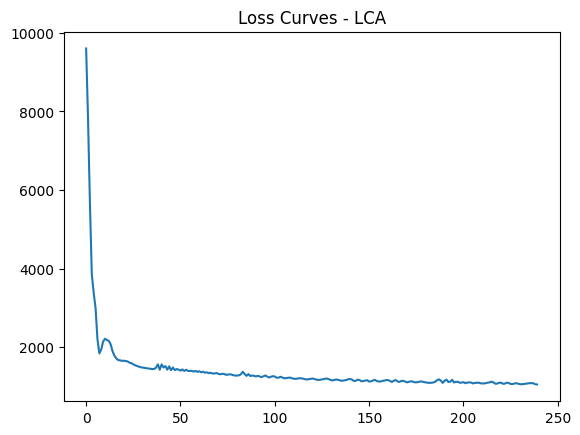

In [ ]:
plt.plot(x, y)
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.title('Loss Curves - LCA')

## Future Scopes

* When training for deployment, train the model for a large number of iterations, say 1000, iterations as although the training will take time, the model would improve a lot, as demonstrated by the loss curves above

* We can add datasets and train the model to also clear the occlusions from fog, sun, snow, rain and many other natural phenonmenons as the logic and working of the AutoEncoder remains same

* When building the deployment model we can

  * Add more layers and neurones
  * Improve the Hardware to work with faster results